<a href="https://colab.research.google.com/github/sherlockieee/cs156/blob/main/CS156_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [218]:
import pandas as pd
import numpy as np
import sklearn
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from matplotlib.pyplot import figure
from collections import Counter
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [219]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/CS156/Assignment 2
accepted_path = 'accepted_2007_to_2018Q4.csv'
rejected_path = 'rejected_2007_to_2018Q4.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CS156/Assignment 2


## Clean accepted data

In [220]:
#get 10% of the data
accepted = pd.read_csv(accepted_path).sample(frac=0.1, random_state = 2022)
accepted.head()


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
753493,140820013,NaN,6000.0,6000.0,6000.0,36 months,14.47,206.44,C,C2,NaN,NaN,OWN,44400.0,Not Verified,Sep-2018,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,031xx,NH,10.62,0.0,Jan-2004,680.0,684.0,0.0,25.0,NaN,8.0,0.0,3007.0,51.0,15.0,w,5170.80,5170.80,...,15874.0,7530.0,2400.0,9974.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1009425,74516633,NaN,7200.0,7200.0,7200.0,36 months,13.67,244.93,C,C3,Seminars and events coordinator,7 years,RENT,45499.0,Source Verified,Mar-2016,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,209xx,MD,21.66,0.0,Sep-2005,720.0,724.0,1.0,NaN,NaN,13.0,0.0,5176.0,27.2,33.0,w,0.00,0.00,...,44788.0,20219.0,6800.0,25788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,Y,Aug-2018,ACTIVE,Aug-2018,1179.0,45.0,12.0
236427,53634605,NaN,13000.0,13000.0,13000.0,60 months,18.25,331.89,E,E1,Bartender,6 years,RENT,80000.0,Source Verified,Jul-2015,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,104xx,NY,10.20,0.0,Aug-1997,670.0,674.0,1.0,31.0,43.0,5.0,2.0,5437.0,90.6,9.0,w,0.00,0.00,...,53049.0,43834.0,4000.0,47049.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1400150,144130349,NaN,15000.0,15000.0,15000.0,60 months,12.98,341.15,B,B5,Sales Manager,2 years,MORTGAGE,81000.0,Not Verified,Nov-2018,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,Home improvement,604xx,IL,13.61,1.0,Dec-1999,740.0,744.0,0.0,23.0,110.0,11.0,1.0,6139.0,40.1,15.0,w,14272.71,14272.71,...,218459.0,33619.0,15300.0,38694.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
98532,62389596,NaN,15000.0,15000.0,15000.0,36 months,6.89,462.41,A,A3,Financial Service Specialist,3 years,MORTGAGE,35000.0,Verified,Oct-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,728xx,AR,33.71,0.0,Apr-1992,780.0,784.0,0.0,NaN,NaN,9.0,0.0,16907.0,25.3,21.0,w,0.00,0.00,...,116738.0,56215.0,65800.0,49938.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [221]:
accepted.shape

(226070, 151)

In [222]:
print(accepted.columns)


Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=151)


In [223]:
accepted_filter = accepted[['loan_amnt', 'title', "fico_range_high", 'fico_range_low', 'dti', 'addr_state', 'emp_length', 'policy_code']]
accepted_filter.isnull().sum()

loan_amnt              1
title               2365
fico_range_high        1
fico_range_low         1
dti                  185
addr_state             1
emp_length         14930
policy_code            1
dtype: int64

There seem to be 2 columns that return everything as NA. We can find and filter them.

In [224]:
accepted_filter[accepted_filter.loan_amnt.isnull()]

,loan_amnt,title,fico_range_high,fico_range_low,dti,addr_state,emp_length,policy_code
1352690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [225]:
accepted_filter.dropna(subset = ["loan_amnt"], inplace=True)
accepted_filter.isnull().sum()

loan_amnt              0
title               2364
fico_range_high        0
fico_range_low         0
dti                  184
addr_state             0
emp_length         14929
policy_code            0
dtype: int64

Looking at employment length, we see that most of them fall for the range > 10 years, thus it makes the most sense to fill in the NA value with the mode (rather than the mean). We also map the categorical values to their corresponding numerical values.

<BarContainer object of 11 artists>

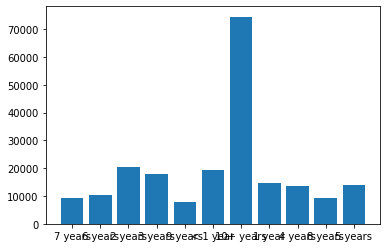

In [226]:

employment_length_keys = list(Counter(accepted.emp_length.dropna()).keys())
employment_length_values = list(Counter(accepted.emp_length.dropna()).values())

plt.bar(employment_length_keys, employment_length_values)


In [227]:
accepted_filter['emp_length'] = accepted_filter.emp_length.fillna(accepted_filter['emp_length'].mode()[0])

For DTI, we can see that it is a roughly normal distribution with a left skew, thus the mean will be heavily skewed due to the large anomaly, thus we should fill the NA values with the median.

(array([2611.,  672.,  591.,  697.,  761.,  482.,   78.,    8.,    3.,
           3.]),
 array([  1. ,  19.3,  37.6,  55.9,  74.2,  92.5, 110.8, 129.1, 147.4,
        165.7, 184. ]),
 <a list of 10 Patch objects>)

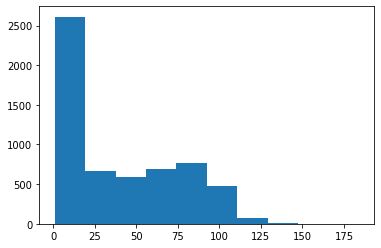

In [228]:
dti_values = list(Counter(accepted.dti.dropna()).values())

plt.hist(dti_values)

In [229]:
accepted_filter['dti'] = accepted_filter.dti.fillna(accepted_filter['dti'].mode()[0])

In [230]:
accepted_filter.isnull().sum()

loan_amnt             0
title              2364
fico_range_high       0
fico_range_low        0
dti                   0
addr_state            0
emp_length            0
policy_code           0
dtype: int64

Finally, I drop the `title` value from the accepted dataset since this information is very hard to encode in the model and is unlikely to provide useful information. I also find the mean between the `fico_range_high` and `fico_range_low` to get an approximation of the risk scores (for rejected).

In [231]:
len(accepted_filter.title.unique())

8616

In [232]:
np.mean(accepted_filter.fico_range_high - accepted_filter.fico_range_low)

4.000234441697004

In [233]:
accepted_filter["risk_score"] = ((accepted_filter.fico_range_high + accepted_filter.fico_range_low)/2).apply(int)
accepted_filter.drop(["fico_range_high", "fico_range_low", "title"], inplace=True, axis=1)

In [234]:
accepted_final = accepted_filter
accepted_final.columns = ["loan_amount", "dti", "state", "employment_length", "policy_code", "risk_score"]
accepted_final.head()

,loan_amount,dti,state,employment_length,policy_code,risk_score
753493,6000.0,10.62,NH,10+ years,1.0,682
1009425,7200.0,21.66,MD,7 years,1.0,722
236427,13000.0,10.20,NY,6 years,1.0,672
1400150,15000.0,13.61,IL,2 years,1.0,742
98532,15000.0,33.71,AR,3 years,1.0,782


In [235]:
accepted_final.isnull().sum()

loan_amount          0
dti                  0
state                0
employment_length    0
policy_code          0
risk_score           0
dtype: int64

## Clean rejected data

In [236]:
#get 1% of the data for rejected so its size is roughly similar to accepted
rejected = pd.read_csv(rejected_path).sample(frac=0.01, random_state = 2022)


In [237]:
print(rejected.shape)
print(rejected.columns)
rejected.head()

(276487, 9)
Index(['Amount Requested', 'Application Date', 'Loan Title', 'Risk_Score',
       'Debt-To-Income Ratio', 'Zip Code', 'State', 'Employment Length',
       'Policy Code'],
      dtype='object')


,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
13662157,18500.0,2016-01-11,credit_card,NaN,12.28%,730xx,OK,5 years,0.0
9960953,10000.0,2018-01-13,Debt consolidation,663.0,0.18%,956xx,CA,< 1 year,0.0
9040032,9900.0,2014-09-10,credit_card,647.0,16.37%,462xx,IN,< 1 year,0.0
12777323,4500.0,2017-08-26,home_improvement,NaN,31.75%,358xx,AL,< 1 year,0.0
13925341,9000.0,2016-02-02,major_purchase,NaN,3.29%,705xx,LA,< 1 year,0.0


In [238]:
rejected.isnull().sum()

Amount Requested             0
Application Date             0
Loan Title                  13
Risk_Score              185252
Debt-To-Income Ratio         0
Zip Code                     2
State                        0
Employment Length         9539
Policy Code                 12
dtype: int64

Drop the columns we will not use and change the names of the rest.

In [239]:
rejected.drop(["Zip Code", "Application Date", "Loan Title"], inplace=True, axis=1)
rejected.columns = ["loan_amount", "risk_score", "dti", "state", "employment_length", "policy_code"]

Since so many values are missing for `Risk_Score`, we can fill it with a completely different value of -1. 

In [240]:
rejected.risk_score = rejected.risk_score.fillna(-1)
rejected.isnull().sum()

loan_amount             0
risk_score              0
dti                     0
state                   0
employment_length    9539
policy_code            12
dtype: int64

For both employment length and policy code, from the distribution, it's best to use the mode to fill in the NA values.

<BarContainer object of 11 artists>

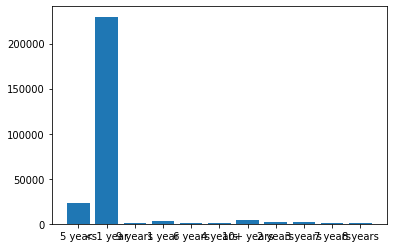

In [241]:
employment_length_keys = list(Counter(rejected.employment_length.dropna()).keys())
employment_length_values = list(Counter(rejected.employment_length.dropna()).values())

plt.bar(employment_length_keys, employment_length_values)

(array([275609.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,    866.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

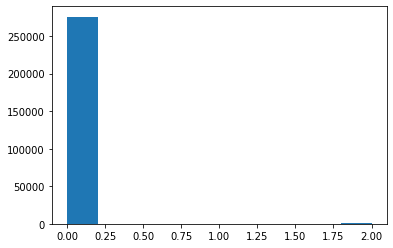

In [242]:
plt.hist(rejected.policy_code.dropna())

Finally, we want to convert the dti value into a float.

In [243]:
rejected.dti = rejected.dti.apply(lambda x: float(x[:-1]))

In [244]:
rejected.employment_length = rejected.employment_length.fillna(rejected.employment_length.mode()[0])
rejected.policy_code = rejected.policy_code.fillna(rejected.policy_code.mode()[0])


In [245]:
rejected_final = rejected
rejected_final.head()


,loan_amount,risk_score,dti,state,employment_length,policy_code
13662157,18500.0,-1.0,12.28,OK,5 years,0.0
9960953,10000.0,663.0,0.18,CA,< 1 year,0.0
9040032,9900.0,647.0,16.37,IN,< 1 year,0.0
12777323,4500.0,-1.0,31.75,AL,< 1 year,0.0
13925341,9000.0,-1.0,3.29,LA,< 1 year,0.0


In [246]:
rejected_final.isna().sum()

loan_amount          0
risk_score           0
dti                  0
state                0
employment_length    0
policy_code          0
dtype: int64

## Combine data


In [247]:
df = pd.concat([accepted_final, rejected_final])
df["results"] = [1] * len(accepted_final) + [0] * len(rejected_final)
df.reset_index(inplace=True)

df.head()

,index,loan_amount,dti,state,employment_length,policy_code,risk_score,results
0,753493,6000.0,10.62,NH,10+ years,1.0,682.0,1
1,1009425,7200.0,21.66,MD,7 years,1.0,722.0,1
2,236427,13000.0,10.20,NY,6 years,1.0,672.0,1
3,1400150,15000.0,13.61,IL,2 years,1.0,742.0,1
4,98532,15000.0,33.71,AR,3 years,1.0,782.0,1


In [248]:
print(len(df))
df.isnull().sum()

502556


index                0
loan_amount          0
dti                  0
state                0
employment_length    0
policy_code          0
risk_score           0
results              0
dtype: int64

Make employment a numerical instead of a categorical type.

In [249]:
employment = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10, 
}

df['employment_length'] = df['employment_length'].map(employment)

In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502556 entries, 0 to 502555
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   index              502556 non-null  int64  
 1   loan_amount        502556 non-null  float64
 2   dti                502556 non-null  float64
 3   state              502556 non-null  object 
 4   employment_length  502556 non-null  int64  
 5   policy_code        502556 non-null  float64
 6   risk_score         502556 non-null  float64
 7   results            502556 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 30.7+ MB


We will convert the state values into categorical variables, and transform dti values to integer values.

In [251]:
print(len(df.state.unique()))
unique_states = sorted(df.state.unique())
print(unique_states)

51
['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']


In [252]:
df = pd.get_dummies(df, columns=['state'])

Finally, we drop the index columns and policy_code columns, both of which are not needed for the logistic regression model.

In [253]:
df = df.drop(columns=["index", "policy_code"], axis=1)
df.head()

,loan_amount,dti,employment_length,risk_score,results,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,6000.0,10.62,10,682.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7200.0,21.66,7,722.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,13000.0,10.20,6,672.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,15000.0,13.61,2,742.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,15000.0,33.71,3,782.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [254]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df.loc[:, df.columns != 'results'], df[['results']], test_size=0.3, random_state=0)

In [255]:
X_train

,loan_amount,dti,employment_length,risk_score,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
501128,10000.0,6.92,0,501.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
290603,10000.0,10.72,5,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
442409,2500.0,4.51,0,612.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
140377,25200.0,26.05,2,692.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
230403,10000.0,39.80,0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439107,25000.0,81.25,0,595.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
117952,6500.0,20.07,10,717.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
435829,6000.0,0.48,0,508.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
305711,2500.0,15.83,0,-1.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [256]:
#normalize the data
from sklearn.preprocessing import StandardScaler

# store the scaler for future use
scalers = {}

# rescale the data
for val in ['loan_amount', 'risk_score', 'dti']:
  # initialize the scaler
  scaler = StandardScaler()

  # fit on the training data
  scaler.fit(X_train[[val]])

  # use the scaler to transform the train and test set. Store into the dictionary
  X_train[val] = scaler.transform(X_train[[val]])
  X_test[val] = scaler.transform(X_test[[val]])
  scalers[val] = scaler

## Logistic regression & cross validation


In [257]:
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors, datasets, metrics
from sklearn.model_selection import cross_val_score

# cross validation accuracy
lr = LogisticRegression(random_state=0)
acc_scores = cross_val_score(lr, X_train, Y_train, cv=5, scoring = "accuracy")
pre_scores = cross_val_score(lr, X_train, Y_train, cv=5, scoring = "precision")
rec_scores = cross_val_score(lr, X_train, Y_train, cv=5, scoring = "recall")
roc_scores = cross_val_score(lr, X_train, Y_train, cv=5, scoring = "roc_auc")
print("Accuracy with cross-validation: %0.2f (+/- %0.2f)" % (acc_scores.mean(), acc_scores.std() * 2))
print("Precision with cross-validation: %0.2f (+/- %0.2f)" % (pre_scores.mean(), pre_scores.std() * 2))
print("Recall with cross-validation: %0.2f (+/- %0.2f)" % (rec_scores.mean(), rec_scores.std() * 2))
print("ROC with cross-validation: %0.2f (+/- %0.2f)" % (roc_scores.mean(), roc_scores.std() * 2))

# metrics results
print('---------------------')
lr = LogisticRegression(random_state=0).fit(X_train, Y_train)
print("Accuracy on train data:", metrics.accuracy_score(Y_train, lr.predict(X_train)))
print("Accuracy on test data:", metrics.accuracy_score(Y_test, lr.predict(X_test)))
print("Precision on train data:", metrics.precision_score(Y_train, lr.predict(X_train)))
print("Precision on test data:", metrics.precision_score(Y_test, lr.predict(X_test)))
print("Recall on train data:", metrics.recall_score(Y_train, lr.predict(X_train)))
print("Recall on test data:", metrics.recall_score(Y_test, lr.predict(X_test)))
print("ROC on train data:", metrics.roc_auc_score(Y_train, lr.predict(X_train)))
print("ROC on test data:", metrics.roc_auc_score(Y_test, lr.predict(X_test)))

Accuracy with cross-validation: 0.94 (+/- 0.00)
Precision with cross-validation: 0.92 (+/- 0.00)
Recall with cross-validation: 0.94 (+/- 0.00)
ROC with cross-validation: 0.98 (+/- 0.00)
---------------------
Accuracy on train data: 0.9401089857840922
Accuracy on test data: 0.9405174872485358
Precision on train data: 0.9241274471030255
Precision on test data: 0.9238236736577907
Recall on train data: 0.9444791804821362
Recall on test data: 0.9455648733242781
ROC on train data: 0.9405056200572499
ROC on test data: 0.9409825932226256


Text(0.5, 0.98, 'Confusion matrix without normalization')

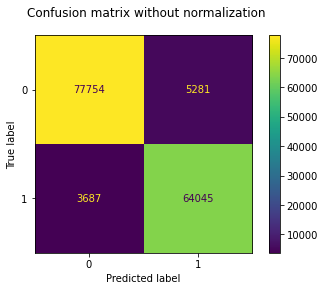

In [258]:
Y_pred = lr.predict(X_test)

display = metrics.ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred, normalize=None)
display.figure_.suptitle("Confusion matrix without normalization")

Text(0.5, 0.98, 'Confusion matrix with normalization')

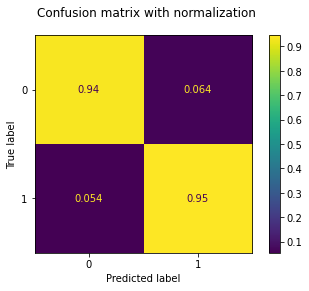

In [259]:
display = metrics.ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred, normalize="true")
display.figure_.suptitle("Confusion matrix with normalization")

## Predicting the highest funded loan amount

In [319]:

def predict_highest_loan(dti, risk_score, employment_length, state, initial_loan, increment = 100, decrement = 100, threshold = 0.8):
    #store original values
    originals = [dti, risk_score, employment_length, state, initial_loan]
    #transform to normalized scale
    initial_loan = scalers['loan_amount'].transform(np.array([[initial_loan]]))[0][0]
    dti = scalers['dti'].transform(np.array([[dti]]))[0][0]
    risk_score = scalers['risk_score'].transform(np.array([[risk_score]]))[0][0]
    if employment_length > 10:
        employment_length = 10
    #find the index of the state in dummies columns
    if state not in unique_states:
        raise ValueError('State value not recognized.')
    inputs = [initial_loan, dti, employment_length, risk_score] + [0] * len(unique_states)
    state_idx = unique_states.index(state)
    inputs[3 + state_idx] = 1
    inputs = np.array(inputs).reshape(1, -1)
    #get whether the loan would be accepted or rejected
    if lr.predict_proba(inputs)[0][1] > threshold:
        print(f"Your loan of {originals[4]} is likely to be accepted.")
        new_loan = originals[-1]
        while lr.predict_proba(inputs)[0][1] > threshold:
            new_loan += increment
            scaled_loan = scalers['loan_amount'].transform(np.array([[new_loan]]))[0][0]
            inputs[0][0] = scaled_loan
            
        max_value = round(new_loan - 0.01, 2)
        print(f"The maximum loan amount you can have is ${max_value}")
    else:
        print(f"Your loan of {originals[4]} is likely to be rejected.")
        new_loan = originals[-1]
        while lr.predict_proba(inputs)[0][1] < threshold and inputs[0][0] >= 0:
            new_loan -= decrement
            scaled_loan = scalers['loan_amount'].transform(np.array([[new_loan]]))[0][0]
            inputs[0][0] = scaled_loan
        min_value = new_loan
        if min_value > 0:
            print(f"The maximum loan amount you can have is ${min_value}")
        else:
            print(f"Loaning Club cannot lend you money right now")




In [320]:
predict_highest_loan(dti = df.dti.mode()[0], risk_score = df.risk_score.mode()[0], 
                     employment_length = df.employment_length.mode()[0], 
                     state = 'CA', initial_loan = 1000)

Your loan of 1000 is likely to be rejected.
The maximum loan amount you can have is $1000


In [321]:
predict_highest_loan(df.dti.mode()[0], 750, 3, state='CO', initial_loan = 35000)

Your loan of 35000 is likely to be accepted.
The maximum loan amount you can have is $101299.99


In [322]:
predict_highest_loan(25, 650, 4, state='CA', initial_loan = 40000)

Your loan of 40000 is likely to be rejected.
The maximum loan amount you can have is $14000
